# <center>Image Segmentation of Artificial Lunar Landscape Images
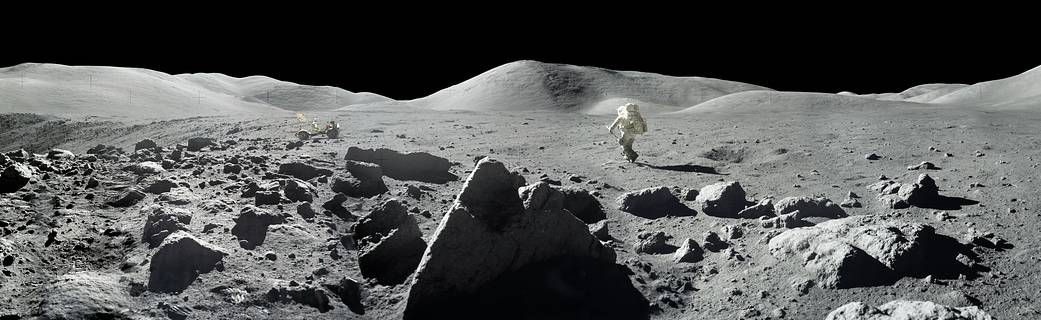    

# Introduction

In this Project we going to use U-net Neural network architecture which is the best NN structure for the purpose of Image segmentation. This NN will be fed with Artificial Lunar Landsacpe dataset, to segment the lunar surface to better preict the route a lunar rover should take to avoid system failure or accidents. This objective is very crucial for a space rover as it is a sensitive and expensive device on foreign space land, there are no possibility of repairs, so best course of action for anyone in this situation is to avoid the failure in the first palce. So for a rover 
<b>Precation is better than cure</b> is the only option.

> This is a Deep learning - computer vision project, where use of techniques like Transefer Learning, Callbacks, U-net model building and optimization, Techinical Documentation and plotting are used.

### I hope everyone gains value from this project, Happy Learning.



## Our goal is to increase the val_iou_score as much as we can for this project using any method. The evaluation of our model will be based on acquired val_iou_score.

### Some pointers to increase the performance

* Increase the number of epochs
* Increase the number of layers in your model
* Using SOTA high performance networks with transfer learning
* Using callbacks and carefully observing your model performance


In [56]:
!pip install segmentation_models

In [57]:
# import the necessary Library

import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf    
import keras
from keras.callbacks import EarlyStopping
from keras.models import Model,load_model
from sklearn.model_selection import train_test_split

* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [58]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

In [59]:
H = 480 # height of image # Height and widht of the image has been changed to 480 in the place of 256 that was originally given. when the original size of image 720 * 480 is rescalled to some lower value there is a some data loss. Therefore, smaller the value bigger will be the data losss, so i have increased the value of dimensions to 480*480 instead of 256*256 that was originally given to us with this assignment notebook.
W = 480 # width of image  #reason for heights and weights increase is given in above line.

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(480 x 480). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

In [60]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’

Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [61]:
batch_size = 16 #batch size of 8 was given by default, I have increased it to 16 due to some results of reseasrch papers showing increase in batcch size increases the performance of the model. Also, if we increase batch size to some the maximum number that is 1 image per batch then there will be the case of over-fitting. reason for explaining this is that, there is a sweet spot of batch size that should be looked for by experimentations and will always be specific to that dataset only. there is no single batch size number which is best for every dataset.

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating U-net Architecture

Here we are going to use transfer learning to build U-net architecture using Vgg-16 backbone.

><u>Transfer Leranring</u>: Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

In [62]:
# In the default assignment notebook unet architecture was implemented using the sequential API. But that was not very efficient and got very un satisfying results. Thus here i have implemented the Transfer learning technique using VGG-16 to build the unet architecture from the pre-trained vgg model.

#### Step 1: Creating a base model 
IMG_SHAPE = (480, 480, 3)

# include_top specify that we don't want to use the top layer (classifier)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Step 2: Freezing the base

# It is important to freeze the convolutional base before you compile and train the model.
# Freezing prevents the weights in a given layer from being updated during training
# VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

#### Step 3: Adding the head

# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))

# base with pretrained model
x = base_model(inputs, training=False)

# head layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)

# Let's take a look at the final model architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0     

In [63]:
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg16 as a backbone
# and pretrained imagenet weights

# segmentation_model basically will create a mirror image of our backbone as expansion path and add to the contraction path
model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Load model and compile

In upcoming cells you will see you of many callbacks like ModelCheckpoint, ReducedLROnPlateau, and earlyStopping. These callbacks are used for the purpose of training our model efficiently. Callbacks control parameters like learning rate or stopping the training process altogether if performance of the model does not increase and beauty of callbacks they control the model during the training run automatically as per the arguments provided by us.

>For our model, I have used IOU score for guaging the performance. IOU score is between 0 and 1, Higher the score better is the performance. For these perpuose we will monitor Val_iou score to see if our model is estimating as per our expectation.

In [64]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping #importing the necessary modules for callbacks
from segmentation_models.metrics import iou_score
import datetime, os

""" Defining Hyperparameters """
img_shape = (480, 480, 3) #input shapes, default one with notebook (256,256,3) to presently this (480,480,3). This is done to accomadate the height and width increase in the input image that we have changed in the previous cells above. 
num_classes = 4
lr = 1e-5 #decreased learning rate gives better generalization
batch_size = 16 #increasing the batch size can provide better performance
epochs = 30 #Increased epochs give better scores

""" Model building and compiling """
# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compiling the model
model.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8, decay=1e-6), #epsilon and decay are added as a way to increase the performance. epsilon is a very small number to prevent any division by zero in the implementation. decay helps us to increase performance by reducing the momentum of the optimizer. Adam uses Momentum and Adaptive Learning Rates to converge faster.
               metrics = metrics)

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size


""" Callbacks """
#A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc). You can use callbacks to: Write TensorBoard logs after every batch of training to monitor your metrics, Periodically save your model to disk, Do early stopping, Get a view on internal states and statistics of a model during training.

current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/LunarModel.h5', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True), # Create a callback that saves the model periodically as training moves along the number of epochs.
             
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6), #This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
                         
             
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'),  #Stop training when a monitored metric has stopped improving.
]

## Train model

In [65]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
        )

Epoch 1/30
488/488 [==============================] - 395s 807ms/step - loss: 0.7925 - iou_score: 0.0467 - f1-score: 0.0756 - val_loss: 0.5849 - val_iou_score: 0.1231 - val_f1-score: 0.1643

Epoch 00001: val_iou_score improved from -inf to 0.12308, saving model to models/LunarModel.h5
Epoch 2/30
488/488 [==============================] - 389s 798ms/step - loss: 0.5418 - iou_score: 0.1450 - f1-score: 0.1810 - val_loss: 0.4564 - val_iou_score: 0.1908 - val_f1-score: 0.2163

Epoch 00002: val_iou_score improved from 0.12308 to 0.19078, saving model to models/LunarModel.h5
Epoch 3/30
488/488 [==============================] - 389s 797ms/step - loss: 0.3749 - iou_score: 0.2233 - f1-score: 0.2359 - val_loss: 0.3234 - val_iou_score: 0.2380 - val_f1-score: 0.2458

Epoch 00003: val_iou_score improved from 0.19078 to 0.23805, saving model to models/LunarModel.h5
Epoch 4/30
488/488 [==============================] - 389s 798ms/step - loss: 0.2824 - iou_score: 0.3170 - f1-score: 0.3235 - val_loss: 

In [66]:
print(model_history.history)

{'loss': [0.7924777269363403, 0.5418400168418884, 0.37491273880004883, 0.2824038565158844, 0.23600627481937408, 0.20271949470043182, 0.17101021111011505, 0.14086639881134033, 0.11671733856201172, 0.09702938795089722, 0.08109670132398605, 0.06816015392541885, 0.05685785412788391, 0.05153694748878479], 'iou_score': [0.04668481647968292, 0.14499376714229584, 0.22329284250736237, 0.31702372431755066, 0.4258477985858917, 0.4512390196323395, 0.4685269296169281, 0.4788545072078705, 0.5095100998878479, 0.5849908590316772, 0.6199173331260681, 0.6738691329956055, 0.6518251299858093, 0.6100153923034668], 'f1-score': [0.07564067840576172, 0.18101716041564941, 0.23594170808792114, 0.32351985573768616, 0.4312715232372284, 0.4560340642929077, 0.4728952944278717, 0.48293402791023254, 0.513386607170105, 0.588782787322998, 0.6236635446548462, 0.6775385737419128, 0.6555022597312927, 0.6135959029197693], 'val_loss': [0.5848733186721802, 0.4563799500465393, 0.3234245777130127, 0.25503283739089966, 0.229936

## Using our model for segmentation of rocks and boulders in some of the unknown test cases of Lunar Surface images.

In [67]:
from skimage.io import imread
from skimage.transform import resize

# function to predict result 
def predict_image(img_path, mask_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = imread(mask_path, as_gray = True)
    mask = mask[:480, :480]
    
    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    
    
    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)
    
    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

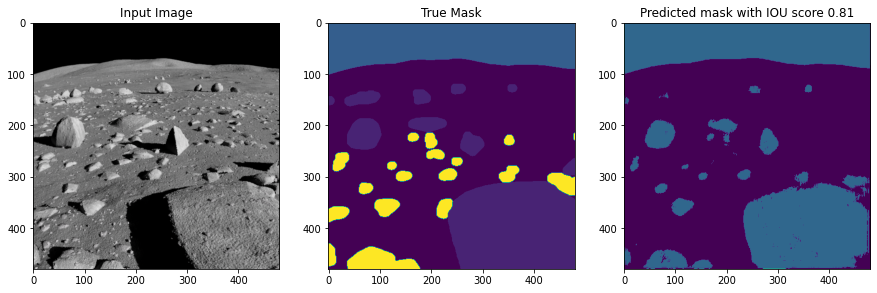

In [68]:
img_path = '../input/artificial-lunar-rocky-landscape-dataset/images/render/render0042.png'
mask_path = '../input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0042.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()

# Documentation and plottings

In [69]:
#Model histories of all the experiments i have done. (to be used in plotting)
history_1 = {'loss': [0.5254549384117126, 0.3412989675998688, 0.2487601637840271, 0.1812313199043274, 0.1368768811225891], 'iou_score': [0.11965442448854446, 0.14698687195777893, 0.1626971960067749, 0.17552980780601501, 0.18463236093521118], 'val_loss': [0.37975144386291504, 0.2783949375152588, 0.20656761527061462, 0.1613922119140625, 0.13200326263904572], 'val_iou_score': [0.13717593252658844, 0.1569286435842514, 0.1707352250814438, 0.17854911088943481, 0.1882665604352951]}

history_2 = {'loss': [0.7117266654968262, 0.45600977540016174, 0.32547199726104736, 0.2279183566570282, 0.16186082363128662, 0.11996787786483765, 0.11696285754442215, 0.0921688973903656, 0.0718517005443573, 0.05767085403203964], 'iou_score': [0.09559328854084015, 0.1265251636505127, 0.14856009185314178, 0.16742736101150513, 0.181313157081604, 0.19015181064605713, 0.18565881252288818, 0.19315171241760254, 0.1987294852733612, 0.20289762318134308], 'val_loss': [0.535325825214386, 0.3988516330718994, 0.2590702772140503, 0.18397140502929688, 0.13768278062343597, 0.09571881592273712, 0.1234917938709259, 0.07880087196826935, 0.06533107906579971, 0.05109025910496712], 'val_iou_score': [0.11426077783107758, 0.13529102504253387, 0.16133055090904236, 0.176660418510437, 0.18747836351394653, 0.17860347032546997, 0.19018268585205078, 0.19373475015163422, 0.19897028803825378, 0.20525702834129333]}

history_3 = {'loss': [0.5231246948242188, 0.29555752873420715, 0.1906273365020752, 0.1472758799791336, 0.11205197125673294, 0.10782746225595474, 0.08973213285207748, 0.0702207162976265, 0.05447293072938919, 0.045201513916254044, 0.03672035038471222, 0.03309774026274681, 0.028841398656368256, 0.026001188904047012, 0.023984219878911972, 0.02635415643453598, 0.026804916560649872, 0.02383970469236374, 0.020823553204536438, 0.01983710378408432, 0.018271274864673615, 0.017161225900053978, 0.01563640683889389, 0.01541261188685894, 0.0139857716858387], 'iou_score': [0.1243908479809761, 0.16222189366817474, 0.1833956390619278, 0.1921129673719406, 0.19765444099903107, 0.1907443106174469, 0.19514665007591248, 0.200332909822464, 0.2048458606004715, 0.207950621843338, 0.21014545857906342, 0.21085435152053833, 0.21234752237796783, 0.21192960441112518, 0.21221977472305298, 0.20339864492416382, 0.20455610752105713, 0.20718446373939514, 0.20775827765464783, 0.20810995995998383, 0.20792241394519806, 0.20899656414985657, 0.20883379876613617, 0.20895922183990479, 0.20606213808059692], 'val_loss': [0.3504341244697571, 0.2270856350660324, 0.15799111127853394, 0.12615768611431122, 0.1073581874370575, 0.09883617609739304, 0.07801088690757751, 0.05247480422258377, 0.045154619961977005, 0.03397982940077782, 0.038976382464170456, 0.025591908022761345, 0.023734865710139275, 0.030592909082770348, 0.022325491532683372, 0.025612615048885345, 0.026377787813544273, 0.020990507677197456, 0.03191310167312622, 0.015842529013752937, 0.015667308121919632, 0.026735998690128326, 0.014911118894815445, 0.014886182732880116, 0.01278657466173172], 'val_iou_score': [0.1469690501689911, 0.17493127286434174, 0.19046643376350403, 0.19754275679588318, 0.196194589138031, 0.1899973303079605, 0.1984904706478119, 0.20007845759391785, 0.20677940547466278, 0.20857937633991241, 0.20819391310214996, 0.2120230495929718, 0.21219679713249207, 0.21205317974090576, 0.21221648156642914, 0.19799432158470154, 0.20467513799667358, 0.20470266044139862, 0.2034219652414322, 0.20694592595100403, 0.20698517560958862, 0.20529471337795258, 0.20798468589782715, 0.20643728971481323, 0.20589295029640198]}

history_4 = {'loss': [0.43286043405532837, 0.2720092535018921, 0.20550419390201569, 0.16345758736133575, 0.12861192226409912, 0.11693187803030014, 0.11703502386808395, 0.1101461723446846, 0.09524888545274734, 0.08133452385663986, 0.07763978838920593, 0.07429588586091995, 0.06552217900753021, 0.05563415214419365, 0.04448946937918663, 0.0377994179725647, 0.03220848739147186, 0.028843320906162262, 0.026018496602773666, 0.023074179887771606, 0.021483756601810455, 0.019931970164179802, 0.01835424266755581, 0.017356084659695625, 0.015776950865983963, 0.016650449484586716, 0.021920375525951385, 0.023347102105617523, 0.020344719290733337, 0.018535394221544266, 0.017241302877664566, 0.015975872054696083, 0.015211859717965126, 0.014745913445949554, 0.014037104323506355, 0.013343127444386482, 0.012828712351620197, 0.012593723833560944, 0.011909034103155136, 0.011844292283058167, 0.011635417118668556, 0.01096460409462452, 0.01081845909357071, 0.010910299606621265, 0.010522273369133472, 0.010119175538420677, 0.00968517642468214, 0.00988337304443121, 0.009502183645963669, 0.009452028200030327], 'iou_score': [0.1380644142627716, 0.1628788560628891, 0.1776314377784729, 0.18744289875030518, 0.19564461708068848, 0.19577080011367798, 0.19281889498233795, 0.19239701330661774, 0.19341067969799042, 0.19471125304698944, 0.1946040242910385, 0.19352731108665466, 0.1949586719274521, 0.1985033005475998, 0.2014687955379486, 0.20285485684871674, 0.20450548827648163, 0.20504659414291382, 0.2066250443458557, 0.2061537653207779, 0.20712536573410034, 0.2073480784893036, 0.2081790417432785, 0.207839235663414, 0.20787252485752106, 0.20082062482833862, 0.19586464762687683, 0.1980830729007721, 0.1998003125190735, 0.19976143538951874, 0.20048119127750397, 0.20061273872852325, 0.20064498484134674, 0.2013738751411438, 0.2011544108390808, 0.2011726349592209, 0.20187801122665405, 0.20123229920864105, 0.20211051404476166, 0.2014688104391098, 0.20192614197731018, 0.20226441323757172, 0.2017780840396881, 0.20251692831516266, 0.20190419256687164, 0.20287074148654938, 0.20263808965682983, 0.20259210467338562, 0.20267267525196075, 0.2030162513256073], 'val_loss': [0.3060072660446167, 0.2395060658454895, 0.1761082261800766, 0.17378093302249908, 0.10429279506206512, 0.111778125166893, 0.10540833324193954, 0.11946316063404083, 0.07873685657978058, 0.07291625440120697, 0.08253438025712967, 0.0778992623090744, 0.05734667181968689, 0.0424986407160759, 0.045263394713401794, 0.034862495958805084, 0.027595985680818558, 0.028429633006453514, 0.030050696805119514, 0.02977176383137703, 0.01606934331357479, 0.017765456810593605, 0.020077552646398544, 0.013626025058329105, 0.019243694841861725, 0.017749212682247162, 0.02026374265551567, 0.019344815984368324, 0.014957351610064507, 0.014733126387000084, 0.026107214391231537, 0.01795090176165104, 0.01644757390022278, 0.01213210728019476, 0.01399934757500887, 0.012668750248849392, 0.013084023259580135, 0.018012898042798042, 0.01058515440672636, 0.010186471976339817, 0.01122604962438345, 0.009914153255522251, 0.010188835673034191, 0.011326152831315994, 0.010078204795718193, 0.014753025025129318, 0.011425738222897053, 0.011663046665489674, 0.02575257048010826, 0.009018166922032833], 'val_iou_score': [0.15508875250816345, 0.1738874763250351, 0.1870644986629486, 0.19103974103927612, 0.19934578239917755, 0.19723312556743622, 0.1927209049463272, 0.19034183025360107, 0.1944122016429901, 0.1972360610961914, 0.19195368885993958, 0.19093334674835205, 0.19459809362888336, 0.19902393221855164, 0.19864872097969055, 0.2017960101366043, 0.20471909642219543, 0.20454718172550201, 0.20509852468967438, 0.20350974798202515, 0.20641197264194489, 0.20637358725070953, 0.20681029558181763, 0.20737609267234802, 0.20777243375778198, 0.196681410074234, 0.19398850202560425, 0.19681796431541443, 0.19713085889816284, 0.1981908679008484, 0.1972302496433258, 0.19943498075008392, 0.19964829087257385, 0.19996923208236694, 0.20052969455718994, 0.20154990255832672, 0.19843357801437378, 0.19997064769268036, 0.2005576491355896, 0.20230022072792053, 0.20011763274669647, 0.20034167170524597, 0.2017102837562561, 0.2020622044801712, 0.20082782208919525, 0.2007213830947876, 0.20169804990291595, 0.20173420011997223, 0.19886332750320435, 0.20218771696090698]}

history_5 = {'loss': [0.5102024078369141, 0.3808255195617676, 0.342494934797287, 0.311972051858902, 0.2863192558288574, 0.2621672451496124, 0.24492156505584717, 0.2295733243227005, 0.21743345260620117, 0.20175980031490326, 0.19247595965862274, 0.18765093386173248, 0.18088099360466003, 0.1699109524488449, 0.16155090928077698, 0.15344645082950592, 0.1452411413192749, 0.13695180416107178, 0.12918643653392792, 0.12343230843544006, 0.11427398025989532, 0.11209619045257568, 0.10334597527980804, 0.09763988107442856, 0.09234745800495148, 0.08627307415008545, 0.08234837651252747, 0.07715348154306412, 0.07279873639345169, 0.06969960033893585, 0.06629111617803574, 0.06323347985744476, 0.06017577648162842, 0.057994455099105835, 0.05530703812837601, 0.051972631365060806, 0.050066690891981125, 0.04775450378656387, 0.04592465981841087, 0.0439772754907608, 0.04198842868208885, 0.04081432521343231, 0.03984374925494194, 0.03676902502775192, 0.03610169515013695, 0.035311710089445114, 0.03384444862604141, 0.0336664617061615, 0.03249666467308998, 0.03101402148604393], 'iou_score': [0.12166621536016464, 0.1407739669084549, 0.14636902511119843, 0.1510908305644989, 0.1559946984052658, 0.16013501584529877, 0.1633060872554779, 0.1664399951696396, 0.16857005655765533, 0.17108242213726044, 0.17263959348201752, 0.17204329371452332, 0.1721697896718979, 0.173943892121315, 0.1758764088153839, 0.1775413453578949, 0.1793416142463684, 0.1805041879415512, 0.1822650134563446, 0.18323563039302826, 0.18447186052799225, 0.1860828548669815, 0.1871851086616516, 0.18871167302131653, 0.18982377648353577, 0.19103163480758667, 0.19204144179821014, 0.19331081211566925, 0.1942155361175537, 0.1954493671655655, 0.19743646681308746, 0.19890424609184265, 0.20067401230335236, 0.20181098580360413, 0.20295237004756927, 0.20278602838516235, 0.2037133425474167, 0.20417049527168274, 0.20449784398078918, 0.20522348582744598, 0.20529404282569885, 0.20589317381381989, 0.20599313080310822, 0.20652642846107483, 0.20690487325191498, 0.20662611722946167, 0.2068103849887848, 0.20695731043815613, 0.2073846310377121, 0.2074553519487381], 'val_loss': [0.39725029468536377, 0.369651734828949, 0.33915477991104126, 0.2991711497306824, 0.2752697765827179, 0.2532455027103424, 0.23558400571346283, 0.22332285344600677, 0.20665243268013, 0.19314906001091003, 0.19083228707313538, 0.1853574514389038, 0.17151376605033875, 0.1655317097902298, 0.15427003800868988, 0.14949224889278412, 0.14130164682865143, 0.13011261820793152, 0.12491822987794876, 0.11641743034124374, 0.11111120879650116, 0.1046392023563385, 0.09700681269168854, 0.09426221996545792, 0.08438940346240997, 0.07954064011573792, 0.07568871229887009, 0.0742909386754036, 0.07055303454399109, 0.06849515438079834, 0.06429896503686905, 0.06515564769506454, 0.05789819359779358, 0.0531732477247715, 0.0531032420694828, 0.05392197519540787, 0.04666830971837044, 0.044355686753988266, 0.041502635926008224, 0.041317738592624664, 0.04078826680779457, 0.03807447478175163, 0.03637712821364403, 0.0346815288066864, 0.03575143218040466, 0.034289050847291946, 0.03085460141301155, 0.02938637137413025, 0.02843034453690052, 0.028198935091495514], 'val_iou_score': [0.13821634650230408, 0.14384981989860535, 0.14728198945522308, 0.15388648211956024, 0.15821336209774017, 0.16279186308383942, 0.1651902049779892, 0.16778111457824707, 0.17044216394424438, 0.17285959422588348, 0.1738942712545395, 0.17178276181221008, 0.17467272281646729, 0.1749056726694107, 0.1778213530778885, 0.17967171967029572, 0.1799134463071823, 0.18201421201229095, 0.18332384526729584, 0.18499749898910522, 0.185831218957901, 0.1862829029560089, 0.18756546080112457, 0.18865129351615906, 0.19108611345291138, 0.19245123863220215, 0.1924789398908615, 0.1933971643447876, 0.19515734910964966, 0.19655124843120575, 0.19930429756641388, 0.19956862926483154, 0.20107555389404297, 0.2026698887348175, 0.20290528237819672, 0.20376071333885193, 0.20390735566616058, 0.2046898454427719, 0.2058342546224594, 0.2060648798942566, 0.20620912313461304, 0.20519010722637177, 0.20734098553657532, 0.20711630582809448, 0.20721940696239471, 0.2070866823196411, 0.20758609473705292, 0.20715589821338654, 0.2081596553325653, 0.20833563804626465]}

history_6 = {'loss': [0.22441129386425018, 0.08437145501375198, 0.04810270294547081, 0.036801546812057495, 0.02931506745517254, 0.024750476703047752, 0.02008216641843319, 0.01715734414756298, 0.015079359523952007, 0.013089154846966267, 0.0116874473169446, 0.01129483338445425, 0.009966034442186356, 0.008590109646320343, 0.008808339945971966, 0.008795803412795067, 0.007681146264076233, 0.006718507036566734, 0.006955177057534456, 0.00918428786098957, 0.007796969264745712, 0.007146245799958706, 0.006463531404733658, 0.006052994169294834, 0.00553742703050375, 0.005131763871759176, 0.004615921061486006, 0.0041485922411084175, 0.006298393476754427, 0.007640054915100336], 'iou_score': [0.1711062639951706, 0.20042046904563904, 0.20869573950767517, 0.20480075478553772, 0.19937124848365784, 0.19781453907489777, 0.199489563703537, 0.20006175339221954, 0.20025542378425598, 0.20069590210914612, 0.1962157040834427, 0.19613897800445557, 0.19687584042549133, 0.1964382827281952, 0.19226773083209991, 0.19329948723316193, 0.19365264475345612, 0.19384226202964783, 0.1911192089319229, 0.1903240978717804, 0.1913575679063797, 0.1913963407278061, 0.1917920559644699, 0.19196674227714539, 0.19218562543392181, 0.1925208419561386, 0.19259092211723328, 0.19274762272834778, 0.19077016413211823, 0.19032232463359833], 'val_loss': [0.11356732249259949, 0.05444024130702019, 0.03845363110303879, 0.02629009261727333, 0.024184897541999817, 0.025789812207221985, 0.01657487452030182, 0.016436666250228882, 0.010876035317778587, 0.015326960943639278, 0.012228039093315601, 0.009516128338873386, 0.008705141954123974, 0.008383819833397865, 0.00807191152125597, 0.007130199111998081, 0.013432868756353855, 0.007950427941977978, 0.007571718189865351, 0.006958231795579195, 0.00678932573646307, 0.006166970357298851, 0.005966098513454199, 0.006146893836557865, 0.005368188954889774, 0.004553425591439009, 0.00415580440312624, 0.003615193534642458, 0.009651674889028072, 0.006191141437739134], 'val_iou_score': [0.19202178716659546, 0.20783935487270355, 0.2052764892578125, 0.20088033378124237, 0.19784602522850037, 0.19727027416229248, 0.20012322068214417, 0.19889184832572937, 0.19983185827732086, 0.19848275184631348, 0.19392573833465576, 0.19614653289318085, 0.1960635632276535, 0.19380976259708405, 0.19161847233772278, 0.19269603490829468, 0.19114503264427185, 0.19315876066684723, 0.1890287697315216, 0.19023527204990387, 0.19093818962574005, 0.19072438776493073, 0.19157977402210236, 0.19194094836711884, 0.19208145141601562, 0.1920149326324463, 0.1920062005519867, 0.1920596957206726, 0.18822459876537323, 0.19026590883731842]}

history_7 = {'loss': [0.08186221867799759, 0.02125968225300312, 0.018100792542099953, 0.14613975584506989, 0.14829495549201965, 0.13139840960502625, 0.1193615049123764, 0.10924960672855377, 0.10075375437736511, 0.09353817999362946, 0.08699561655521393, 0.08135757595300674, 0.07633999735116959], 'iou_score': [0.19674725830554962, 0.2045295089483261, 0.2027662992477417, 0.16953948140144348, 0.1662207990884781, 0.16958744823932648, 0.1719551682472229, 0.17405007779598236, 0.1758207231760025, 0.17733807861804962, 0.17868009209632874, 0.17987126111984253, 0.18094168603420258], 'val_loss': [0.021308284252882004, 0.012292802333831787, 0.010381177999079227, 0.1743612289428711, 0.14683492481708527, 0.12148582190275192, 0.11423883587121964, 0.11329975724220276, 0.09572690725326538, 0.09188910573720932, 0.07185018807649612, 0.08710998296737671, 0.08491721004247665], 'val_iou_score': [0.19325916469097137, 0.19800803065299988, 0.1959214061498642, 0.15824702382087708, 0.16435961425304413, 0.17032311856746674, 0.17307724058628082, 0.17343758046627045, 0.1756078153848648, 0.1777110993862152, 0.18039003014564514, 0.17996156215667725, 0.17772965133190155]}

history_8 = {'loss': [0.07765202224254608, 0.04012763872742653, 0.02456658147275448, 0.4974954426288605, 0.3394964039325714], 'iou_score': [0.21540233492851257, 0.21004462242126465, 0.20592689514160156, 0.10284782201051712, 0.18557944893836975], 'f1-score': [0.23038724064826965, 0.2278778851032257, 0.22548066079616547, 0.12334077060222626, 0.21213017404079437], 'val_loss': [0.2353668510913849, 0.08914081752300262, 0.13925518095493317, 0.44899982213974, 0.2575310170650482], 'val_iou_score': [0.1883765012025833, 0.19088131189346313, 0.19058242440223694, 0.14998742938041687, 0.18947358429431915], 'val_f1-score': [0.21465866267681122, 0.21632610261440277, 0.21611249446868896, 0.18721459805965424, 0.2154756337404251], 'lr': [0.0007, 0.0007, 0.0007, 0.0007, 0.0007]}

history_9 = {'loss': [0.25536635518074036, 0.04437649995088577, 0.03212974593043327, 0.02850687876343727, 0.018274173140525818], 'iou_score': [0.36826464533805847, 0.7057791948318481, 0.6297565698623657, 0.5204053521156311, 0.5541524887084961], 'f1-score': [0.3827938735485077, 0.7152298092842102, 0.649531364440918, 0.5456835627555847, 0.5792655944824219], 'val_loss': [0.0813726857304573, 0.032043855637311935, 0.036784738302230835, 0.019282961264252663, 0.023523643612861633], 'val_iou_score': [0.4210038185119629, 0.7208210229873657, 0.6471740007400513, 0.44030866026878357, 0.6841242909431458], 'val_f1-score': [0.42846226692199707, 0.7308229804039001, 0.6729212403297424, 0.46600133180618286, 0.7098129987716675], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

history_10 = {'loss': [0.23851731419563293, 0.04979284852743149, 0.028097860515117645, 0.01984509453177452, 0.01931244693696499, 0.01908903941512108, 0.01335589773952961, 0.011098015122115612], 'iou_score': [0.3502723276615143, 0.942891001701355, 0.9778903126716614, 0.9813889861106873, 0.8599538207054138, 0.7898415327072144, 0.7391858100891113, 0.8353567719459534], 'f1-score': [0.3660469055175781, 0.9557108879089355, 0.9880200028419495, 0.9901788830757141, 0.8827288150787354, 0.8154869675636292, 0.7648126482963562, 0.861030101776123], 'val_loss': [0.09513457119464874, 0.03804868832230568, 0.029048174619674683, 0.013090172782540321, 0.028353895992040634, 0.013774966821074486, 0.011165433563292027, 0.010544698685407639], 'val_iou_score': [0.8325262665748596, 0.9403762817382812, 0.9411243796348572, 0.941012442111969, 0.8067363500595093, 0.6962046027183533, 0.8906941413879395, 0.8108275532722473], 'val_f1-score': [0.8401544094085693, 0.9660575985908508, 0.9665541648864746, 0.966468334197998, 0.8325780034065247, 0.7220103740692139, 0.9165480136871338, 0.8366550803184509], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-05]}

history_11 = {'loss': [0.8636157512664795, 0.5200220942497253, 0.3703117370605469, 0.27520492672920227, 0.2126648724079132, 0.16758722066879272, 0.13606050610542297, 0.12108047306537628, 0.11918606609106064, 0.10031867027282715, 0.08689174056053162, 0.08248075842857361, 0.07183043658733368, 0.06233608350157738, 0.054739098995923996, 0.04750872403383255, 0.04095785319805145, 0.03540455549955368, 0.03087575174868107, 0.027014287188649178, 0.024023957550525665, 0.021178696304559708, 0.01915539801120758, 0.017731769010424614, 0.020218390971422195, 0.018970998004078865, 0.01683988980948925], 'iou_score': [0.05949559062719345, 0.15820351243019104, 0.222634419798851, 0.2358514666557312, 0.23852922022342682, 0.23959915339946747, 0.24023430049419403, 0.2433292716741562, 0.3224536180496216, 0.430336594581604, 0.46740859746932983, 0.49706101417541504, 0.5005703568458557, 0.5740548372268677, 0.7122536301612854, 0.8050721883773804, 0.8934906721115112, 0.9312769770622253, 0.9613186717033386, 0.966772735118866, 0.9805991649627686, 0.9802860021591187, 0.979714572429657, 0.9687208533287048, 0.8608725666999817, 0.9369176626205444, 0.9394068717956543], 'f1-score': [0.09138340502977371, 0.19163082540035248, 0.23535382747650146, 0.24268490076065063, 0.24410730600357056, 0.24466928839683533, 0.24500177800655365, 0.24784070253372192, 0.3270989954471588, 0.43483996391296387, 0.4720696210861206, 0.5024871230125427, 0.5057849287986755, 0.5791651010513306, 0.7174199819564819, 0.8101970553398132, 0.8987162113189697, 0.9368028044700623, 0.9671791791915894, 0.9732019901275635, 0.9875144958496094, 0.9878214001655579, 0.9877490401268005, 0.9789468050003052, 0.8825709819793701, 0.9625535011291504, 0.9650598168373108], 'val_loss': [0.6398588418960571, 0.42101866006851196, 0.3186495900154114, 0.2292756587266922, 0.1791539490222931, 0.1445494145154953, 0.1246056854724884, 0.11849658191204071, 0.11012744903564453, 0.09340988099575043, 0.08058678358793259, 0.07328937202692032, 0.06615941971540451, 0.057678017765283585, 0.054042916744947433, 0.04342668503522873, 0.03899380937218666, 0.030416980385780334, 0.029261121526360512, 0.025874800980091095, 0.02172091230750084, 0.019237197935581207, 0.017424173653125763, 0.019484125077724457, 0.018989136442542076, 0.01788090355694294, 0.016667935997247696], 'val_iou_score': [0.11151456087827682, 0.20963385701179504, 0.230991393327713, 0.23695772886276245, 0.23787859082221985, 0.26025718450546265, 0.242630273103714, 0.2522260546684265, 0.390399694442749, 0.4249049127101898, 0.47929272055625916, 0.4951736629009247, 0.5158281922340393, 0.6925669312477112, 0.6843937635421753, 0.7958791255950928, 0.822160542011261, 0.9219556450843811, 0.8990094661712646, 0.946975827217102, 0.9818085432052612, 0.9829071760177612, 0.9804774522781372, 0.9622408151626587, 0.9316645264625549, 0.9400121569633484, 0.9399330019950867], 'val_f1-score': [0.1537923663854599, 0.2279573380947113, 0.2400800585746765, 0.24328169226646423, 0.24376936256885529, 0.26524749398231506, 0.24723097681999207, 0.25713303685188293, 0.39489278197288513, 0.42955732345581055, 0.4843918979167938, 0.500516414642334, 0.5210933089256287, 0.6975942254066467, 0.6894075274467468, 0.8014758229255676, 0.8279229998588562, 0.9280052185058594, 0.9052563309669495, 0.9537927508354187, 0.9895811676979065, 0.9911239147186279, 0.9888719916343689, 0.9795198440551758, 0.9567912220954895, 0.9658195376396179, 0.9657825231552124], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}

history_12 = {'loss': [1.10402512550354, 0.6968660354614258, 0.4829825162887573, 0.34657353162765503, 0.245592400431633, 0.17345145344734192, 0.12884974479675293, 0.10497108846902847, 0.09088542312383652, 0.07282628118991852, 0.05911711975932121, 0.04951058328151703, 0.04795759171247482, 0.04971630126237869, 0.043796975165605545, 0.037239477038383484, 0.03019285760819912, 0.02499614655971527, 0.02083481289446354, 0.01871059462428093], 'iou_score': [0.00034596610930748284, 0.056064456701278687, 0.1592652052640915, 0.2254491150379181, 0.23574529588222504, 0.27487096190452576, 0.47873830795288086, 0.6107555627822876, 0.7093473672866821, 0.7209895253181458, 0.738129198551178, 0.7381952404975891, 0.7483747601509094, 0.8894405961036682, 0.9337852597236633, 0.9400963187217712, 0.9403308033943176, 0.9406468868255615, 0.9393938779830933, 0.9402631521224976], 'f1-score': [0.0006876197876408696, 0.08454328775405884, 0.1925888955593109, 0.2369854748249054, 0.2426365315914154, 0.28046420216560364, 0.483854740858078, 0.6157022714614868, 0.7139384746551514, 0.7256470918655396, 0.742922306060791, 0.7436844706535339, 0.7613065838813782, 0.9148187041282654, 0.9594293832778931, 0.9656959176063538, 0.9660178422927856, 0.9662115573883057, 0.9650560617446899, 0.9659679532051086], 'val_loss': [0.9167906045913696, 0.6057925820350647, 0.4347604215145111, 0.29967689514160156, 0.19758346676826477, 0.16538557410240173, 0.11606411635875702, 0.10580872744321823, 0.08510822802782059, 0.07512935250997543, 0.054352596402168274, 0.042300403118133545, 0.051481302827596664, 0.04772331193089485, 0.040585555136203766, 0.034711532294750214, 0.03409281745553017, 0.0225748922675848, 0.01897892914712429, 0.01874903216958046], 'val_iou_score': [0.00015642802463844419, 0.10603293776512146, 0.20620004832744598, 0.2552530765533447, 0.37888556718826294, 0.5332543253898621, 0.6022454500198364, 0.6518527865409851, 0.6763817071914673, 0.7069272994995117, 0.6803513169288635, 0.724108099937439, 0.7794564962387085, 0.9240010380744934, 0.9402820467948914, 0.9401692152023315, 0.9400290846824646, 0.9401673078536987, 0.9401614665985107, 0.9401830434799194], 'val_f1-score': [0.00031265418510884047, 0.148043692111969, 0.2259034961462021, 0.26355311274528503, 0.3849530816078186, 0.5389978885650635, 0.6073459386825562, 0.6567471623420715, 0.6813026070594788, 0.7119409441947937, 0.6853393316268921, 0.7306941747665405, 0.8047877550125122, 0.9496763944625854, 0.9659754633903503, 0.9659102559089661, 0.9658215045928955, 0.9659123420715332, 0.965911865234375, 0.9659134149551392], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}

In [70]:
# visulization code
import matplotlib.pyplot as plt
def Plotting(history1, history2):
        plt.plot(history1['val_iou_score'])
        plt.plot(history2['val_iou_score'])
        plt.title('Model Performance')
        plt.xlabel('epochs')
        plt.ylabel('val_iou_score')
        plt.legend(['Val_iou_score of 1st observation', 'Val_iou_score of 2st observation'])
        plt.show()

In [71]:
# Code block to create tables in Python
# import module
from tabulate import tabulate
def Table_to_compare(history1,history2): 
    # assign data
    mydata = [
        [history1, history2]
    ]

    # create header
    head = ["Before Improvement", "After Improvement"]

    # display table
    print(tabulate(mydata, headers=head, tablefmt="grid"))

# 1. Plotting for impact of epoch increment on basic u-net's val_iou_score

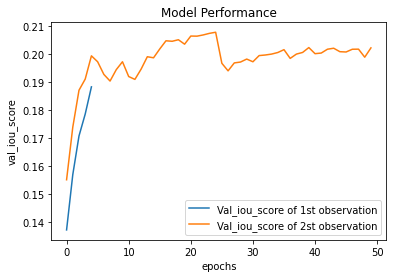


+----------------------+---------------------+
|   Before Improvement |   After Improvement |
+======================+=====================+
|             0.188267 |            0.202188 |
+----------------------+---------------------+

From this comparison of two training runs 1st(history_1) with 5 epochs and 2nd(history_4) one under considration is with 50 epochs it can be seen that there is increase in val_iou_score slightly but it is there. I Didn't increased the number of epochs from 50 as you can see from the graph there is a no real benefit to increasinf the epochs anymore to improve performance


In [72]:
Plotting(history_1,history_4)
print()
Table_to_compare(history_1["val_iou_score"][-1],history_4["val_iou_score"][-1])
print("\nFrom this comparison of two training runs 1st(history_1) with 5 epochs and 2nd(history_4) one under considration is with 50 epochs it can be seen that there is increase in val_iou_score slightly but it is there. I Didn't increased the number of epochs from 50 as you can see from the graph there is a no real benefit to increasinf the epochs anymore to improve performance")

# 2. Plotting for impact of learning rate decrement on basic u-net's val_iou_score

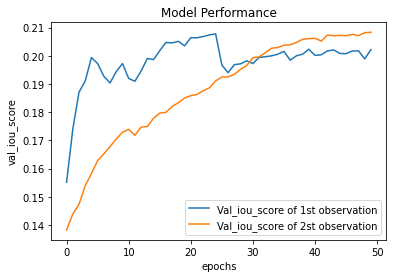


+----------------------+---------------------+
|   Before Improvement |   After Improvement |
+======================+=====================+
|             0.202188 |            0.208336 |
+----------------------+---------------------+

As it is evident from the plot there is a stable increase with each epoch with lesser learning rate and also a slight increase in val_iou_score


In [73]:
Plotting(history_4,history_5)
print()
Table_to_compare(history_4["val_iou_score"][-1],history_5["val_iou_score"][-1])
print("\nAs it is evident from the plot there is a stable increase with each epoch with lesser learning rate and also a slight increase in val_iou_score")

# 3. Plotting for impact of using transfer learning technique to build unet on val_iou_score

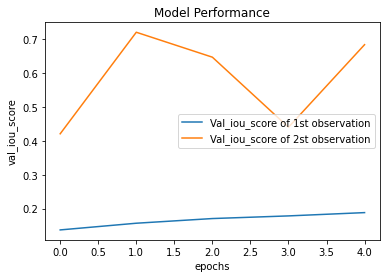


+----------------------+---------------------+
|   Before Improvement |   After Improvement |
+======================+=====================+
|             0.188267 |            0.684124 |
+----------------------+---------------------+

There is great boost in performance by using transfer learning technique to build u-net from a base model Vgg-16, transfer learning is so beneficial that even from the 1st epoch we get a considerable amount of performance as compared to just basic u-net model trained on our dataset.


In [74]:
Plotting(history_1,history_9)
print()
Table_to_compare(history_1["val_iou_score"][-1],history_9["val_iou_score"][-1])
print("\nThere is great boost in performance by using transfer learning technique to build u-net from a base model Vgg-16, transfer learning is so beneficial that even from the 1st epoch we get a considerable amount of performance as compared to just basic u-net model trained on our dataset.")

# 4. Plotting to show impact of inceasing epochs on our updated model

<u>Improvements that are included in the training run under consideration</u>

increased to epochs = 30 but stopped after 8 epochs ,Some parameters that i specified in adam optimizer after internet research epsilon=1e-8, decay=1e-6. Also used ReducedLRonplateau with min lr = 1e-6 and reduction in lr by factor 0.1 and patience = 5. other than these changes everything is same as previous experiment

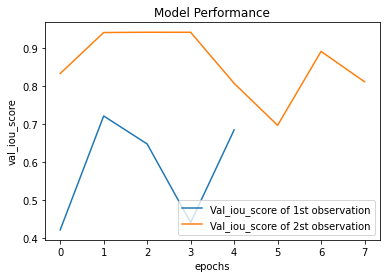


+----------------------+---------------------+
|   Before Improvement |   After Improvement |
+======================+=====================+
|             0.684124 |            0.810828 |
+----------------------+---------------------+


In [75]:
Plotting(history_9,history_10)
print()
Table_to_compare(history_9["val_iou_score"][-1],history_10["val_iou_score"][-1])

# 5. Plotting to show impact of Decreasing learning rate on our updated model in 11th training run 

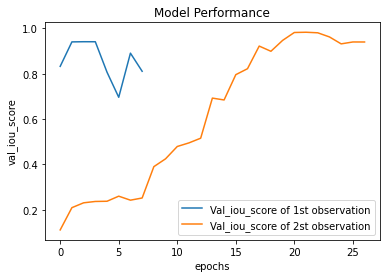


+----------------------+---------------------+
|   Before Improvement |   After Improvement |
+======================+=====================+
|             0.810828 |            0.939933 |
+----------------------+---------------------+

overall increase in val_iou score with steady increase in performance every epoch. We can infer from this that with higher learning rate we get unstable model and improvement over epoch is lost because even after 5 epochs there was not a little bit of increase in val_iou score, But on the other hand, we see that with less learning rate we are obtaining a steady growth over every passing epoch which is desirable.


In [76]:
Plotting(history_10,history_11)
print()
Table_to_compare(history_10["val_iou_score"][-1],history_11["val_iou_score"][-1])
print("\noverall increase in val_iou score with steady increase in performance every epoch. We can infer from this that with higher learning rate we get unstable model and improvement over epoch is lost because even after 5 epochs there was not a little bit of increase in val_iou score, But on the other hand, we see that with less learning rate we are obtaining a steady growth over every passing epoch which is desirable.")

# FINAL IMPROVEMENT SUMMARY TABLE

|Experiment# | Description | Increase in val_iou from | Increase in val_iou to (considering val_iou score of final epoch of the corresponding training run) |
|:---| :----: | :---:| :---:|
| 1 | default notebook with no improvements | NA | 0.1882 |
| 2 | Increased epoch = 5, which was given in the deafult notebook to epoch = 10 | 0.1882| 0.2052 |
| 3 | Increased epoch = 10 to epoch = 20 | 0.2052 | 0.2058 |
| 4 | Increased epoch = 20 to epoch = 50 | 0.2058 | 0.2021 |
| 5 | Kept the epoch = 50 as earlier training run but decreased the learning rate of lr = 1e-4 to lr = 1e-5 | 0.2021 | 0.2083 |
| 6 | Tried experimenting with batch size. I used lr = 1e-4, decreased the to batch_size = 8 and used epochs = 30 | 0.2083 | 0.1902 |
| 7 | After intensive internet research and things taught to us in the sessions for optimization implemented some callbacks like earlystopping and cmodel checkpointing. Used paramters listed here lr = 7e-4 batch_size = 4 epochs = 30(with early stopped at 13th epoch,because model failed to increase val_iou after 13 epochs) | 0.1902 | 0.1777 |
| 8 | Just used some callbacks and carried out ad-hoc testing of results with the listed parameters lr = 7e-4 batch_size = 16 epochs = 5. No real improvements in results  | 0.1777 | 0.1894 |
| 9 | from here on out tranfer learning technique was implemented and tremendous performance increase was attained with the listed parameters, lr = 1e-4 batch_size = 16 epochs = 5.Also, one major change i made in terms of data provided to the model is that i increased the Height and width of the image that is going to be fed to the model as shown in the here(H = 480, W = 480 instead of H,W = 256 that was givven to us in the default notebook), This was very necessary as lunar dataset had images of 720 * 480 dimensions and as we downscale the H,W values, our model get less pixel data as compared to original image to train on. | 0.1894 | 0.6841 |
| 10 |  increased to epochs = 30 but stopped after 8 epochs ,Some parameters that i specified in adam optimizer after internet research epsilon=1e-8, decay=1e-6. Also used ReducedLRonplateau with min lr = 1e-6 and reduction in lr by factor 0.1 and patience = 5. other than these changes everything is same as previous experiment | 0.6841 | 0.8108 |
| 11 | Just decreased the learning rate to lr = 1e-5,other than this change everything is same as previous experiment. During training i used epochs = 30 but stopped after 27 epochs due to early stopping | 0.8108 | 0.9399 |
| 12 | no changes were made from previous training run, wanted to be sure if model reproduces same result, which is true as there is difference in iou score of just 0.0001 | 0.9399 | 0.9401 |

# This is collection of model histories of all the experiments that i ran with some characteristics shown along side with it corresponding to that specific training run

### 1st history(epoch = 5):

{'loss': [0.5254549384117126, 0.3412989675998688, 0.2487601637840271, 0.1812313199043274, 0.1368768811225891], 'iou_score': [0.11965442448854446, 0.14698687195777893, 0.1626971960067749, 0.17552980780601501, 0.18463236093521118], 'val_loss': [0.37975144386291504, 0.2783949375152588, 0.20656761527061462, 0.1613922119140625, 0.13200326263904572], 'val_iou_score': [0.13717593252658844, 0.1569286435842514, 0.1707352250814438, 0.17854911088943481, 0.1882665604352951]}

### 2nd history(epoch = 10):

{'loss': [0.7117266654968262, 0.45600977540016174, 0.32547199726104736, 0.2279183566570282, 0.16186082363128662, 0.11996787786483765, 0.11696285754442215, 0.0921688973903656, 0.0718517005443573, 0.05767085403203964], 'iou_score': [0.09559328854084015, 0.1265251636505127, 0.14856009185314178, 0.16742736101150513, 0.181313157081604, 0.19015181064605713, 0.18565881252288818, 0.19315171241760254, 0.1987294852733612, 0.20289762318134308], 'val_loss': [0.535325825214386, 0.3988516330718994, 0.2590702772140503, 0.18397140502929688, 0.13768278062343597, 0.09571881592273712, 0.1234917938709259, 0.07880087196826935, 0.06533107906579971, 0.05109025910496712], 'val_iou_score': [0.11426077783107758, 0.13529102504253387, 0.16133055090904236, 0.176660418510437, 0.18747836351394653, 0.17860347032546997, 0.19018268585205078, 0.19373475015163422, 0.19897028803825378, 0.20525702834129333]}

### 3rd history(epoch = 20):

{'loss': [0.5231246948242188, 0.29555752873420715, 0.1906273365020752, 0.1472758799791336, 0.11205197125673294, 0.10782746225595474, 0.08973213285207748, 0.0702207162976265, 0.05447293072938919, 0.045201513916254044, 0.03672035038471222, 0.03309774026274681, 0.028841398656368256, 0.026001188904047012, 0.023984219878911972, 0.02635415643453598, 0.026804916560649872, 0.02383970469236374, 0.020823553204536438, 0.01983710378408432, 0.018271274864673615, 0.017161225900053978, 0.01563640683889389, 0.01541261188685894, 0.0139857716858387], 'iou_score': [0.1243908479809761, 0.16222189366817474, 0.1833956390619278, 0.1921129673719406, 0.19765444099903107, 0.1907443106174469, 0.19514665007591248, 0.200332909822464, 0.2048458606004715, 0.207950621843338, 0.21014545857906342, 0.21085435152053833, 0.21234752237796783, 0.21192960441112518, 0.21221977472305298, 0.20339864492416382, 0.20455610752105713, 0.20718446373939514, 0.20775827765464783, 0.20810995995998383, 0.20792241394519806, 0.20899656414985657, 0.20883379876613617, 0.20895922183990479, 0.20606213808059692], 'val_loss': [0.3504341244697571, 0.2270856350660324, 0.15799111127853394, 0.12615768611431122, 0.1073581874370575, 0.09883617609739304, 0.07801088690757751, 0.05247480422258377, 0.045154619961977005, 0.03397982940077782, 0.038976382464170456, 0.025591908022761345, 0.023734865710139275, 0.030592909082770348, 0.022325491532683372, 0.025612615048885345, 0.026377787813544273, 0.020990507677197456, 0.03191310167312622, 0.015842529013752937, 0.015667308121919632, 0.026735998690128326, 0.014911118894815445, 0.014886182732880116, 0.01278657466173172], 'val_iou_score': [0.1469690501689911, 0.17493127286434174, 0.19046643376350403, 0.19754275679588318, 0.196194589138031, 0.1899973303079605, 0.1984904706478119, 0.20007845759391785, 0.20677940547466278, 0.20857937633991241, 0.20819391310214996, 0.2120230495929718, 0.21219679713249207, 0.21205317974090576, 0.21221648156642914, 0.19799432158470154, 0.20467513799667358, 0.20470266044139862, 0.2034219652414322, 0.20694592595100403, 0.20698517560958862, 0.20529471337795258, 0.20798468589782715, 0.20643728971481323, 0.20589295029640198]}

### 4th history(epoch = 50):

{'loss': [0.43286043405532837, 0.2720092535018921, 0.20550419390201569, 0.16345758736133575, 0.12861192226409912, 0.11693187803030014, 0.11703502386808395, 0.1101461723446846, 0.09524888545274734, 0.08133452385663986, 0.07763978838920593, 0.07429588586091995, 0.06552217900753021, 0.05563415214419365, 0.04448946937918663, 0.0377994179725647, 0.03220848739147186, 0.028843320906162262, 0.026018496602773666, 0.023074179887771606, 0.021483756601810455, 0.019931970164179802, 0.01835424266755581, 0.017356084659695625, 0.015776950865983963, 0.016650449484586716, 0.021920375525951385, 0.023347102105617523, 0.020344719290733337, 0.018535394221544266, 0.017241302877664566, 0.015975872054696083, 0.015211859717965126, 0.014745913445949554, 0.014037104323506355, 0.013343127444386482, 0.012828712351620197, 0.012593723833560944, 0.011909034103155136, 0.011844292283058167, 0.011635417118668556, 0.01096460409462452, 0.01081845909357071, 0.010910299606621265, 0.010522273369133472, 0.010119175538420677, 0.00968517642468214, 0.00988337304443121, 0.009502183645963669, 0.009452028200030327], 'iou_score': [0.1380644142627716, 0.1628788560628891, 0.1776314377784729, 0.18744289875030518, 0.19564461708068848, 0.19577080011367798, 0.19281889498233795, 0.19239701330661774, 0.19341067969799042, 0.19471125304698944, 0.1946040242910385, 0.19352731108665466, 0.1949586719274521, 0.1985033005475998, 0.2014687955379486, 0.20285485684871674, 0.20450548827648163, 0.20504659414291382, 0.2066250443458557, 0.2061537653207779, 0.20712536573410034, 0.2073480784893036, 0.2081790417432785, 0.207839235663414, 0.20787252485752106, 0.20082062482833862, 0.19586464762687683, 0.1980830729007721, 0.1998003125190735, 0.19976143538951874, 0.20048119127750397, 0.20061273872852325, 0.20064498484134674, 0.2013738751411438, 0.2011544108390808, 0.2011726349592209, 0.20187801122665405, 0.20123229920864105, 0.20211051404476166, 0.2014688104391098, 0.20192614197731018, 0.20226441323757172, 0.2017780840396881, 0.20251692831516266, 0.20190419256687164, 0.20287074148654938, 0.20263808965682983, 0.20259210467338562, 0.20267267525196075, 0.2030162513256073], 'val_loss': [0.3060072660446167, 0.2395060658454895, 0.1761082261800766, 0.17378093302249908, 0.10429279506206512, 0.111778125166893, 0.10540833324193954, 0.11946316063404083, 0.07873685657978058, 0.07291625440120697, 0.08253438025712967, 0.0778992623090744, 0.05734667181968689, 0.0424986407160759, 0.045263394713401794, 0.034862495958805084, 0.027595985680818558, 0.028429633006453514, 0.030050696805119514, 0.02977176383137703, 0.01606934331357479, 0.017765456810593605, 0.020077552646398544, 0.013626025058329105, 0.019243694841861725, 0.017749212682247162, 0.02026374265551567, 0.019344815984368324, 0.014957351610064507, 0.014733126387000084, 0.026107214391231537, 0.01795090176165104, 0.01644757390022278, 0.01213210728019476, 0.01399934757500887, 0.012668750248849392, 0.013084023259580135, 0.018012898042798042, 0.01058515440672636, 0.010186471976339817, 0.01122604962438345, 0.009914153255522251, 0.010188835673034191, 0.011326152831315994, 0.010078204795718193, 0.014753025025129318, 0.011425738222897053, 0.011663046665489674, 0.02575257048010826, 0.009018166922032833], 'val_iou_score': [0.15508875250816345, 0.1738874763250351, 0.1870644986629486, 0.19103974103927612, 0.19934578239917755, 0.19723312556743622, 0.1927209049463272, 0.19034183025360107, 0.1944122016429901, 0.1972360610961914, 0.19195368885993958, 0.19093334674835205, 0.19459809362888336, 0.19902393221855164, 0.19864872097969055, 0.2017960101366043, 0.20471909642219543, 0.20454718172550201, 0.20509852468967438, 0.20350974798202515, 0.20641197264194489, 0.20637358725070953, 0.20681029558181763, 0.20737609267234802, 0.20777243375778198, 0.196681410074234, 0.19398850202560425, 0.19681796431541443, 0.19713085889816284, 0.1981908679008484, 0.1972302496433258, 0.19943498075008392, 0.19964829087257385, 0.19996923208236694, 0.20052969455718994, 0.20154990255832672, 0.19843357801437378, 0.19997064769268036, 0.2005576491355896, 0.20230022072792053, 0.20011763274669647, 0.20034167170524597, 0.2017102837562561, 0.2020622044801712, 0.20082782208919525, 0.2007213830947876, 0.20169804990291595, 0.20173420011997223, 0.19886332750320435, 0.20218771696090698]}

### 5th history (Epoch = 50 , learning rate = 1e-5):

{'loss': [0.5102024078369141, 0.3808255195617676, 0.342494934797287, 0.311972051858902, 0.2863192558288574, 0.2621672451496124, 0.24492156505584717, 0.2295733243227005, 0.21743345260620117, 0.20175980031490326, 0.19247595965862274, 0.18765093386173248, 0.18088099360466003, 0.1699109524488449, 0.16155090928077698, 0.15344645082950592, 0.1452411413192749, 0.13695180416107178, 0.12918643653392792, 0.12343230843544006, 0.11427398025989532, 0.11209619045257568, 0.10334597527980804, 0.09763988107442856, 0.09234745800495148, 0.08627307415008545, 0.08234837651252747, 0.07715348154306412, 0.07279873639345169, 0.06969960033893585, 0.06629111617803574, 0.06323347985744476, 0.06017577648162842, 0.057994455099105835, 0.05530703812837601, 0.051972631365060806, 0.050066690891981125, 0.04775450378656387, 0.04592465981841087, 0.0439772754907608, 0.04198842868208885, 0.04081432521343231, 0.03984374925494194, 0.03676902502775192, 0.03610169515013695, 0.035311710089445114, 0.03384444862604141, 0.0336664617061615, 0.03249666467308998, 0.03101402148604393], 'iou_score': [0.12166621536016464, 0.1407739669084549, 0.14636902511119843, 0.1510908305644989, 0.1559946984052658, 0.16013501584529877, 0.1633060872554779, 0.1664399951696396, 0.16857005655765533, 0.17108242213726044, 0.17263959348201752, 0.17204329371452332, 0.1721697896718979, 0.173943892121315, 0.1758764088153839, 0.1775413453578949, 0.1793416142463684, 0.1805041879415512, 0.1822650134563446, 0.18323563039302826, 0.18447186052799225, 0.1860828548669815, 0.1871851086616516, 0.18871167302131653, 0.18982377648353577, 0.19103163480758667, 0.19204144179821014, 0.19331081211566925, 0.1942155361175537, 0.1954493671655655, 0.19743646681308746, 0.19890424609184265, 0.20067401230335236, 0.20181098580360413, 0.20295237004756927, 0.20278602838516235, 0.2037133425474167, 0.20417049527168274, 0.20449784398078918, 0.20522348582744598, 0.20529404282569885, 0.20589317381381989, 0.20599313080310822, 0.20652642846107483, 0.20690487325191498, 0.20662611722946167, 0.2068103849887848, 0.20695731043815613, 0.2073846310377121, 0.2074553519487381], 'val_loss': [0.39725029468536377, 0.369651734828949, 0.33915477991104126, 0.2991711497306824, 0.2752697765827179, 0.2532455027103424, 0.23558400571346283, 0.22332285344600677, 0.20665243268013, 0.19314906001091003, 0.19083228707313538, 0.1853574514389038, 0.17151376605033875, 0.1655317097902298, 0.15427003800868988, 0.14949224889278412, 0.14130164682865143, 0.13011261820793152, 0.12491822987794876, 0.11641743034124374, 0.11111120879650116, 0.1046392023563385, 0.09700681269168854, 0.09426221996545792, 0.08438940346240997, 0.07954064011573792, 0.07568871229887009, 0.0742909386754036, 0.07055303454399109, 0.06849515438079834, 0.06429896503686905, 0.06515564769506454, 0.05789819359779358, 0.0531732477247715, 0.0531032420694828, 0.05392197519540787, 0.04666830971837044, 0.044355686753988266, 0.041502635926008224, 0.041317738592624664, 0.04078826680779457, 0.03807447478175163, 0.03637712821364403, 0.0346815288066864, 0.03575143218040466, 0.034289050847291946, 0.03085460141301155, 0.02938637137413025, 0.02843034453690052, 0.028198935091495514], 'val_iou_score': [0.13821634650230408, 0.14384981989860535, 0.14728198945522308, 0.15388648211956024, 0.15821336209774017, 0.16279186308383942, 0.1651902049779892, 0.16778111457824707, 0.17044216394424438, 0.17285959422588348, 0.1738942712545395, 0.17178276181221008, 0.17467272281646729, 0.1749056726694107, 0.1778213530778885, 0.17967171967029572, 0.1799134463071823, 0.18201421201229095, 0.18332384526729584, 0.18499749898910522, 0.185831218957901, 0.1862829029560089, 0.18756546080112457, 0.18865129351615906, 0.19108611345291138, 0.19245123863220215, 0.1924789398908615, 0.1933971643447876, 0.19515734910964966, 0.19655124843120575, 0.19930429756641388, 0.19956862926483154, 0.20107555389404297, 0.2026698887348175, 0.20290528237819672, 0.20376071333885193, 0.20390735566616058, 0.2046898454427719, 0.2058342546224594, 0.2060648798942566, 0.20620912313461304, 0.20519010722637177, 0.20734098553657532, 0.20711630582809448, 0.20721940696239471, 0.2070866823196411, 0.20758609473705292, 0.20715589821338654, 0.2081596553325653, 0.20833563804626465]}

### 6th history lr = 1e-4 batch_size = 8 epochs = 30:

{'loss': [0.22441129386425018, 0.08437145501375198, 0.04810270294547081, 0.036801546812057495, 0.02931506745517254, 0.024750476703047752, 0.02008216641843319, 0.01715734414756298, 0.015079359523952007, 0.013089154846966267, 0.0116874473169446, 0.01129483338445425, 0.009966034442186356, 0.008590109646320343, 0.008808339945971966, 0.008795803412795067, 0.007681146264076233, 0.006718507036566734, 0.006955177057534456, 0.00918428786098957, 0.007796969264745712, 0.007146245799958706, 0.006463531404733658, 0.006052994169294834, 0.00553742703050375, 0.005131763871759176, 0.004615921061486006, 0.0041485922411084175, 0.006298393476754427, 0.007640054915100336], 'iou_score': [0.1711062639951706, 0.20042046904563904, 0.20869573950767517, 0.20480075478553772, 0.19937124848365784, 0.19781453907489777, 0.199489563703537, 0.20006175339221954, 0.20025542378425598, 0.20069590210914612, 0.1962157040834427, 0.19613897800445557, 0.19687584042549133, 0.1964382827281952, 0.19226773083209991, 0.19329948723316193, 0.19365264475345612, 0.19384226202964783, 0.1911192089319229, 0.1903240978717804, 0.1913575679063797, 0.1913963407278061, 0.1917920559644699, 0.19196674227714539, 0.19218562543392181, 0.1925208419561386, 0.19259092211723328, 0.19274762272834778, 0.19077016413211823, 0.19032232463359833], 'val_loss': [0.11356732249259949, 0.05444024130702019, 0.03845363110303879, 0.02629009261727333, 0.024184897541999817, 0.025789812207221985, 0.01657487452030182, 0.016436666250228882, 0.010876035317778587, 0.015326960943639278, 0.012228039093315601, 0.009516128338873386, 0.008705141954123974, 0.008383819833397865, 0.00807191152125597, 0.007130199111998081, 0.013432868756353855, 0.007950427941977978, 0.007571718189865351, 0.006958231795579195, 0.00678932573646307, 0.006166970357298851, 0.005966098513454199, 0.006146893836557865, 0.005368188954889774, 0.004553425591439009, 0.00415580440312624, 0.003615193534642458, 0.009651674889028072, 0.006191141437739134], 'val_iou_score': [0.19202178716659546, 0.20783935487270355, 0.2052764892578125, 0.20088033378124237, 0.19784602522850037, 0.19727027416229248, 0.20012322068214417, 0.19889184832572937, 0.19983185827732086, 0.19848275184631348, 0.19392573833465576, 0.19614653289318085, 0.1960635632276535, 0.19380976259708405, 0.19161847233772278, 0.19269603490829468, 0.19114503264427185, 0.19315876066684723, 0.1890287697315216, 0.19023527204990387, 0.19093818962574005, 0.19072438776493073, 0.19157977402210236, 0.19194094836711884, 0.19208145141601562, 0.1920149326324463, 0.1920062005519867, 0.1920596957206726, 0.18822459876537323, 0.19026590883731842]}

### 7th history lr = 7e-4 batch_size = 4 epochs = 30(with early stopped at 13th epoch,failded to increase val_iou after 13 epochs):

{'loss': [0.08186221867799759, 0.02125968225300312, 0.018100792542099953, 0.14613975584506989, 0.14829495549201965, 0.13139840960502625, 0.1193615049123764, 0.10924960672855377, 0.10075375437736511, 0.09353817999362946, 0.08699561655521393, 0.08135757595300674, 0.07633999735116959], 'iou_score': [0.19674725830554962, 0.2045295089483261, 0.2027662992477417, 0.16953948140144348, 0.1662207990884781, 0.16958744823932648, 0.1719551682472229, 0.17405007779598236, 0.1758207231760025, 0.17733807861804962, 0.17868009209632874, 0.17987126111984253, 0.18094168603420258], 'val_loss': [0.021308284252882004, 0.012292802333831787, 0.010381177999079227, 0.1743612289428711, 0.14683492481708527, 0.12148582190275192, 0.11423883587121964, 0.11329975724220276, 0.09572690725326538, 0.09188910573720932, 0.07185018807649612, 0.08710998296737671, 0.08491721004247665], 'val_iou_score': [0.19325916469097137, 0.19800803065299988, 0.1959214061498642, 0.15824702382087708, 0.16435961425304413, 0.17032311856746674, 0.17307724058628082, 0.17343758046627045, 0.1756078153848648, 0.1777110993862152, 0.18039003014564514, 0.17996156215667725, 0.17772965133190155]}



### 8th history lr = 7e-4 batch_size = 16 epochs = 5:

{'loss': [0.07765202224254608, 0.04012763872742653, 0.02456658147275448, 0.4974954426288605, 0.3394964039325714], 'iou_score': [0.21540233492851257, 0.21004462242126465, 0.20592689514160156, 0.10284782201051712, 0.18557944893836975], 'f1-score': [0.23038724064826965, 0.2278778851032257, 0.22548066079616547, 0.12334077060222626, 0.21213017404079437], 'val_loss': [0.2353668510913849, 0.08914081752300262, 0.13925518095493317, 0.44899982213974, 0.2575310170650482], 'val_iou_score': [0.1883765012025833, 0.19088131189346313, 0.19058242440223694, 0.14998742938041687, 0.18947358429431915], 'val_f1-score': [0.21465866267681122, 0.21632610261440277, 0.21611249446868896, 0.18721459805965424, 0.2154756337404251], 'lr': [0.0007, 0.0007, 0.0007, 0.0007, 0.0007]}

## from here tranfer learning technique was implemented and tremendous performance increase was attained

### 9th history lr = 1e-4 batch_size = 16 epochs = 5(H = 480, W = 480 instead of H,W = 256):

{'loss': [0.25536635518074036, 0.04437649995088577, 0.03212974593043327, 0.02850687876343727, 0.018274173140525818], 'iou_score': [0.36826464533805847, 0.7057791948318481, 0.6297565698623657, 0.5204053521156311, 0.5541524887084961], 'f1-score': [0.3827938735485077, 0.7152298092842102, 0.649531364440918, 0.5456835627555847, 0.5792655944824219], 'val_loss': [0.0813726857304573, 0.032043855637311935, 0.036784738302230835, 0.019282961264252663, 0.023523643612861633], 'val_iou_score': [0.4210038185119629, 0.7208210229873657, 0.6471740007400513, 0.44030866026878357, 0.6841242909431458], 'val_f1-score': [0.42846226692199707, 0.7308229804039001, 0.6729212403297424, 0.46600133180618286, 0.7098129987716675], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

### 10th history lr = 1e-4 batch_size = 16 epochs = 30 but stopped after 8 epochs (H = 480, W = 480 instead of H,W = 256), epsilon=1e-8, decay=1e-6 :

{'loss': [0.23851731419563293, 0.04979284852743149, 0.028097860515117645, 0.01984509453177452, 0.01931244693696499, 0.01908903941512108, 0.01335589773952961, 0.011098015122115612], 'iou_score': [0.3502723276615143, 0.942891001701355, 0.9778903126716614, 0.9813889861106873, 0.8599538207054138, 0.7898415327072144, 0.7391858100891113, 0.8353567719459534], 'f1-score': [0.3660469055175781, 0.9557108879089355, 0.9880200028419495, 0.9901788830757141, 0.8827288150787354, 0.8154869675636292, 0.7648126482963562, 0.861030101776123], 'val_loss': [0.09513457119464874, 0.03804868832230568, 0.029048174619674683, 0.013090172782540321, 0.028353895992040634, 0.013774966821074486, 0.011165433563292027, 0.010544698685407639], 'val_iou_score': [0.8325262665748596, 0.9403762817382812, 0.9411243796348572, 0.941012442111969, 0.8067363500595093, 0.6962046027183533, 0.8906941413879395, 0.8108275532722473], 'val_f1-score': [0.8401544094085693, 0.9660575985908508, 0.9665541648864746, 0.966468334197998, 0.8325780034065247, 0.7220103740692139, 0.9165480136871338, 0.8366550803184509], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-05]}

### 11th history lr = 1e-5 batch_size = 16 epochs = 30 but stopped after 27 epochs (H = 480, W = 480 instead of H,W = 256), epsilon=1e-8, decay=1e-6 :

{'loss': [0.8636157512664795, 0.5200220942497253, 0.3703117370605469, 0.27520492672920227, 0.2126648724079132, 0.16758722066879272, 0.13606050610542297, 0.12108047306537628, 0.11918606609106064, 0.10031867027282715, 0.08689174056053162, 0.08248075842857361, 0.07183043658733368, 0.06233608350157738, 0.054739098995923996, 0.04750872403383255, 0.04095785319805145, 0.03540455549955368, 0.03087575174868107, 0.027014287188649178, 0.024023957550525665, 0.021178696304559708, 0.01915539801120758, 0.017731769010424614, 0.020218390971422195, 0.018970998004078865, 0.01683988980948925], 'iou_score': [0.05949559062719345, 0.15820351243019104, 0.222634419798851, 0.2358514666557312, 0.23852922022342682, 0.23959915339946747, 0.24023430049419403, 0.2433292716741562, 0.3224536180496216, 0.430336594581604, 0.46740859746932983, 0.49706101417541504, 0.5005703568458557, 0.5740548372268677, 0.7122536301612854, 0.8050721883773804, 0.8934906721115112, 0.9312769770622253, 0.9613186717033386, 0.966772735118866, 0.9805991649627686, 0.9802860021591187, 0.979714572429657, 0.9687208533287048, 0.8608725666999817, 0.9369176626205444, 0.9394068717956543], 'f1-score': [0.09138340502977371, 0.19163082540035248, 0.23535382747650146, 0.24268490076065063, 0.24410730600357056, 0.24466928839683533, 0.24500177800655365, 0.24784070253372192, 0.3270989954471588, 0.43483996391296387, 0.4720696210861206, 0.5024871230125427, 0.5057849287986755, 0.5791651010513306, 0.7174199819564819, 0.8101970553398132, 0.8987162113189697, 0.9368028044700623, 0.9671791791915894, 0.9732019901275635, 0.9875144958496094, 0.9878214001655579, 0.9877490401268005, 0.9789468050003052, 0.8825709819793701, 0.9625535011291504, 0.9650598168373108], 'val_loss': [0.6398588418960571, 0.42101866006851196, 0.3186495900154114, 0.2292756587266922, 0.1791539490222931, 0.1445494145154953, 0.1246056854724884, 0.11849658191204071, 0.11012744903564453, 0.09340988099575043, 0.08058678358793259, 0.07328937202692032, 0.06615941971540451, 0.057678017765283585, 0.054042916744947433, 0.04342668503522873, 0.03899380937218666, 0.030416980385780334, 0.029261121526360512, 0.025874800980091095, 0.02172091230750084, 0.019237197935581207, 0.017424173653125763, 0.019484125077724457, 0.018989136442542076, 0.01788090355694294, 0.016667935997247696], 'val_iou_score': [0.11151456087827682, 0.20963385701179504, 0.230991393327713, 0.23695772886276245, 0.23787859082221985, 0.26025718450546265, 0.242630273103714, 0.2522260546684265, 0.390399694442749, 0.4249049127101898, 0.47929272055625916, 0.4951736629009247, 0.5158281922340393, 0.6925669312477112, 0.6843937635421753, 0.7958791255950928, 0.822160542011261, 0.9219556450843811, 0.8990094661712646, 0.946975827217102, 0.9818085432052612, 0.9829071760177612, 0.9804774522781372, 0.9622408151626587, 0.9316645264625549, 0.9400121569633484, 0.9399330019950867], 'val_f1-score': [0.1537923663854599, 0.2279573380947113, 0.2400800585746765, 0.24328169226646423, 0.24376936256885529, 0.26524749398231506, 0.24723097681999207, 0.25713303685188293, 0.39489278197288513, 0.42955732345581055, 0.4843918979167938, 0.500516414642334, 0.5210933089256287, 0.6975942254066467, 0.6894075274467468, 0.8014758229255676, 0.8279229998588562, 0.9280052185058594, 0.9052563309669495, 0.9537927508354187, 0.9895811676979065, 0.9911239147186279, 0.9888719916343689, 0.9795198440551758, 0.9567912220954895, 0.9658195376396179, 0.9657825231552124], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}

### 12th history lr = 1e-5 batch_size = 16 epochs = 30 but stopped after 20 epochs (H = 480, W = 480 instead of H,W = 256), epsilon=1e-8, decay=1e-6 :


{'loss': [1.10402512550354, 0.6968660354614258, 0.4829825162887573, 0.34657353162765503, 0.245592400431633, 0.17345145344734192, 0.12884974479675293, 0.10497108846902847, 0.09088542312383652, 0.07282628118991852, 0.05911711975932121, 0.04951058328151703, 0.04795759171247482, 0.04971630126237869, 0.043796975165605545, 0.037239477038383484, 0.03019285760819912, 0.02499614655971527, 0.02083481289446354, 0.01871059462428093], 'iou_score': [0.00034596610930748284, 0.056064456701278687, 0.1592652052640915, 0.2254491150379181, 0.23574529588222504, 0.27487096190452576, 0.47873830795288086, 0.6107555627822876, 0.7093473672866821, 0.7209895253181458, 0.738129198551178, 0.7381952404975891, 0.7483747601509094, 0.8894405961036682, 0.9337852597236633, 0.9400963187217712, 0.9403308033943176, 0.9406468868255615, 0.9393938779830933, 0.9402631521224976], 'f1-score': [0.0006876197876408696, 0.08454328775405884, 0.1925888955593109, 0.2369854748249054, 0.2426365315914154, 0.28046420216560364, 0.483854740858078, 0.6157022714614868, 0.7139384746551514, 0.7256470918655396, 0.742922306060791, 0.7436844706535339, 0.7613065838813782, 0.9148187041282654, 0.9594293832778931, 0.9656959176063538, 0.9660178422927856, 0.9662115573883057, 0.9650560617446899, 0.9659679532051086], 'val_loss': [0.9167906045913696, 0.6057925820350647, 0.4347604215145111, 0.29967689514160156, 0.19758346676826477, 0.16538557410240173, 0.11606411635875702, 0.10580872744321823, 0.08510822802782059, 0.07512935250997543, 0.054352596402168274, 0.042300403118133545, 0.051481302827596664, 0.04772331193089485, 0.040585555136203766, 0.034711532294750214, 0.03409281745553017, 0.0225748922675848, 0.01897892914712429, 0.01874903216958046], 'val_iou_score': [0.00015642802463844419, 0.10603293776512146, 0.20620004832744598, 0.2552530765533447, 0.37888556718826294, 0.5332543253898621, 0.6022454500198364, 0.6518527865409851, 0.6763817071914673, 0.7069272994995117, 0.6803513169288635, 0.724108099937439, 0.7794564962387085, 0.9240010380744934, 0.9402820467948914, 0.9401692152023315, 0.9400290846824646, 0.9401673078536987, 0.9401614665985107, 0.9401830434799194], 'val_f1-score': [0.00031265418510884047, 0.148043692111969, 0.2259034961462021, 0.26355311274528503, 0.3849530816078186, 0.5389978885650635, 0.6073459386825562, 0.6567471623420715, 0.6813026070594788, 0.7119409441947937, 0.6853393316268921, 0.7306941747665405, 0.8047877550125122, 0.9496763944625854, 0.9659754633903503, 0.9659102559089661, 0.9658215045928955, 0.9659123420715332, 0.965911865234375, 0.9659134149551392], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}



## Final Model History:

{'loss': [1.10402512550354, 0.6968660354614258, 0.4829825162887573, 0.34657353162765503, 0.245592400431633, 0.17345145344734192, 0.12884974479675293, 0.10497108846902847, 0.09088542312383652, 0.07282628118991852, 0.05911711975932121, 0.04951058328151703, 0.04795759171247482, 0.04971630126237869, 0.043796975165605545, 0.037239477038383484, 0.03019285760819912, 0.02499614655971527, 0.02083481289446354, 0.01871059462428093], 'iou_score': [0.00034596610930748284, 0.056064456701278687, 0.1592652052640915, 0.2254491150379181, 0.23574529588222504, 0.27487096190452576, 0.47873830795288086, 0.6107555627822876, 0.7093473672866821, 0.7209895253181458, 0.738129198551178, 0.7381952404975891, 0.7483747601509094, 0.8894405961036682, 0.9337852597236633, 0.9400963187217712, 0.9403308033943176, 0.9406468868255615, 0.9393938779830933, 0.9402631521224976], 'f1-score': [0.0006876197876408696, 0.08454328775405884, 0.1925888955593109, 0.2369854748249054, 0.2426365315914154, 0.28046420216560364, 0.483854740858078, 0.6157022714614868, 0.7139384746551514, 0.7256470918655396, 0.742922306060791, 0.7436844706535339, 0.7613065838813782, 0.9148187041282654, 0.9594293832778931, 0.9656959176063538, 0.9660178422927856, 0.9662115573883057, 0.9650560617446899, 0.9659679532051086], 'val_loss': [0.9167906045913696, 0.6057925820350647, 0.4347604215145111, 0.29967689514160156, 0.19758346676826477, 0.16538557410240173, 0.11606411635875702, 0.10580872744321823, 0.08510822802782059, 0.07512935250997543, 0.054352596402168274, 0.042300403118133545, 0.051481302827596664, 0.04772331193089485, 0.040585555136203766, 0.034711532294750214, 0.03409281745553017, 0.0225748922675848, 0.01897892914712429, 0.01874903216958046], 'val_iou_score': [0.00015642802463844419, 0.10603293776512146, 0.20620004832744598, 0.2552530765533447, 0.37888556718826294, 0.5332543253898621, 0.6022454500198364, 0.6518527865409851, 0.6763817071914673, 0.7069272994995117, 0.6803513169288635, 0.724108099937439, 0.7794564962387085, 0.9240010380744934, 0.9402820467948914, 0.9401692152023315, 0.9400290846824646, 0.9401673078536987, 0.9401614665985107, 0.9401830434799194], 'val_f1-score': [0.00031265418510884047, 0.148043692111969, 0.2259034961462021, 0.26355311274528503, 0.3849530816078186, 0.5389978885650635, 0.6073459386825562, 0.6567471623420715, 0.6813026070594788, 0.7119409441947937, 0.6853393316268921, 0.7306941747665405, 0.8047877550125122, 0.9496763944625854, 0.9659754633903503, 0.9659102559089661, 0.9658215045928955, 0.9659123420715332, 0.965911865234375, 0.9659134149551392], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}


# Thank you for checking out my Notebook, If you like it please upvote it😊 and do share your feedback and suggestions in the comments, I will love to hear from the community🙌